In [24]:
import pandas as pd
import numpy as np
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Input, Bidirectional

In [25]:
data = pd.read_csv('car-reviews.csv')

positive_data = data[691:]
negative_data = data[:691]

train_positive = positive_data[:553]
test_positive = positive_data[553:]

train_negative = negative_data[:553]
test_negative = negative_data[553:]

raw_training_data = pd.concat([train_positive, train_negative]).reset_index(drop=True)
raw_testing_data = pd.concat([test_positive, test_negative]).reset_index(drop=True)

raw_training_data['Sentiment'] = np.where(raw_training_data['Sentiment'] == 'Pos', 1, 0)
raw_testing_data['Sentiment'] = np.where(raw_testing_data['Sentiment'] == 'Pos', 1, 0)

In [31]:
# Data Preparation

tr_texts = list(raw_training_data['Review'])
tr_labels = list(raw_training_data['Sentiment'])  

tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(tr_texts)
sequences = tokenizer.texts_to_sequences(tr_texts)

data = pad_sequences(sequences, maxlen=100)



# Model Definition

model = Sequential()
model.add(Input(shape=(100,))) 
model.add(Embedding(input_dim=10000, output_dim=128))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
# model.add(Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2)))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])




# Training

labels = np.array(tr_labels)
history = model.fit(data, labels, batch_size=32, epochs=10, validation_split=0.2)



# Evaluation

tes_texts = list(raw_testing_data['Review'])
tes_labels = list(raw_testing_data['Sentiment'])   

test_sequences = tokenizer.texts_to_sequences(tes_texts)
test_data = pad_sequences(test_sequences, maxlen=100)

probabilities = model.predict(test_data)


predictions = []

for idx in range(len(probabilities)):
    if probabilities[idx][0] > 0.5:
        predictions.append(1)
    else:
        predictions.append(0)


accuracy = np.sum(predictions == np.array(tes_labels)) / len(tes_labels)
print(f"Accuracy: {round(accuracy, 3)}")

Epoch 1/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.6070 - loss: 0.6764 - val_accuracy: 0.0000e+00 - val_loss: 0.9552
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - accuracy: 0.6241 - loss: 0.6112 - val_accuracy: 0.6396 - val_loss: 0.6611
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.8496 - loss: 0.4245 - val_accuracy: 0.2883 - val_loss: 1.5953
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.9088 - loss: 0.2626 - val_accuracy: 0.5586 - val_loss: 0.8710
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.9472 - loss: 0.2047 - val_accuracy: 0.4550 - val_loss: 1.0413
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.9632 - loss: 0.1255 - val_accuracy: 0.5360 - val_loss: 1.2982
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 0.9846 - loss: 0.0494 - val_accuracy: 0.6577 - val_loss: 1.2070
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.9851 - loss: 0.0447 - val_accuracy: 0.6081

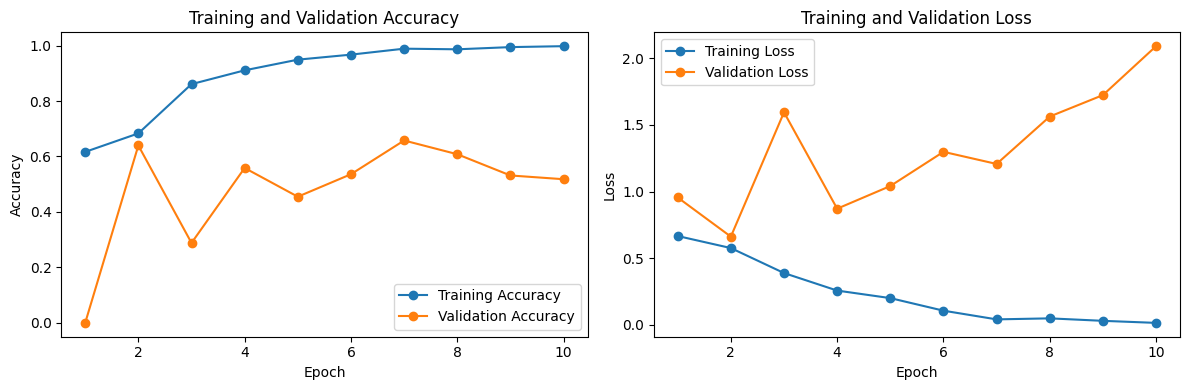

In [32]:
# Training history data
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_accuracy) + 1)

plt.figure(figsize=(12, 4))

# Plotting accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, training_accuracy, label='Training Accuracy', marker='o')
plt.plot(epochs, validation_accuracy, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(epochs, training_loss, label='Training Loss', marker='o')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()